#### 국회의원 현황
* https://www.assembly.go.kr/portal/cnts/cntsCont/dataA.do?cntsDivCd=NAAS&menuNo=600137

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

headers = {
    'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'
}

member_list_300 = []
for index in range(1,31):
    url = f'https://www.assembly.go.kr/portal/cnts/cntsNaas/findNaasThx01.json?pageIndex={index}'
    print(url)
    res = requests.get(url, headers=headers)
    #print(res.status_code)
    if res.ok:
        #print(res.json()['resultList'])
        member_list_10 = []
        for member in res.json()['resultList']: #[{},{}]
            member_list_10.append(member) 
        
        #print(member_list_10)
        member_list_300.extend(member_list_10)
    else:
        print(res.status_code)
print(len(member_list_300))
print(member_list_300[:3])

In [5]:
from pprint import pprint

pprint(member_list_300[:2])

[{'cmitNm': '교육위원회',
  'electGbnNm': '비례대표',
  'hgNm': '강경숙',
  'mImgUrl': '/static/portal/img/openassm/new/68f83caf0c9e4546b1694ead863f45ce.jpg',
  'mLinkUrl': '/members/22nd/KANGKYUNGSOOK',
  'mThumbImgUrl': '/static/portal/img/openassm/new/thumb/68f83caf0c9e4546b1694ead863f45ce.jpg',
  'monaCd': 'T2T8225E',
  'openNaId': 'KANGKYUNGSOOK',
  'origNm': '비례대표',
  'polyNm': '조국혁신당',
  'reeleGbnNm': '초선',
  'rnum': 1,
  'sexGbnNm': '여',
  'st': '22',
  'unitNm': '제22대'},
 {'cmitNm': '국방위원회',
  'electGbnNm': '지역구',
  'hgNm': '강대식',
  'mImgUrl': '/static/portal/img/openassm/new/d1fe9f0902d84f0ba74f721d3298be7f.png',
  'mLinkUrl': '/members/22nd/KANGDAESIK',
  'mThumbImgUrl': '/static/portal/img/openassm/new/thumb/d1fe9f0902d84f0ba74f721d3298be7f.png',
  'monaCd': 'L2I9861C',
  'openNaId': 'KANGDAESIK',
  'origNm': '대구 동구군위군을',
  'polyNm': '국민의힘',
  'reeleGbnNm': '재선',
  'rnum': 2,
  'sexGbnNm': '남',
  'st': '22',
  'unitNm': '제22대'}]


#### Json 데이터와 상세페이지 스크래핑 데이터 를 혼합해서 상세정보 저장하기

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin

print('===> 스크래핑 시작')
#297명의 정보를 저장하는 List
member_detail_list = []

headers = {
    'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'
}

for idx,member in enumerate(member_list_300,1):
    # 'mLinkUrl': '/members/22nd/KANGDAESIK'
    mem_sub_link = member['mLinkUrl']
    detail_url = f'https://www.assembly.go.kr{mem_sub_link}'
    res = requests.get(detail_url, headers=headers)
    print(res.ok, idx, detail_url)
    
    if res.ok:
        soup = BeautifulSoup(res.text, 'html.parser')
        
        #1명의 정보를 저장하는 dict 선언
        member_detail_dict = {}
        
        li_tags = soup.select('ul.list li:nth-of-type(n+4)')
        #print(li_tags)
        # for li in li_tags:
        #     print(type(li.find('dt')))
        #     print(li.find('dt').text)
        
        dt_list = [li_tag.find('dt').text for li_tag in li_tags]
        #print(dt_list)

        dd_list = []        
        for li_tag in li_tags:
            dd_tag = li_tag.find('dd')
            pattern = re.compile(f'[\n\r\t]')
            dd_text = pattern.sub('',dd_tag.text.strip()).replace(" ","")
            dd_list.append(dd_text)
        #print(dd_list)
        
        member_detail_dict = dict(zip(dt_list, dd_list))

        # 'hgNm': '강경숙'
        member_detail_dict['이름'] = member['hgNm']   
        # 'polyNm': '조국혁신당'    
        member_detail_dict['정당'] = member['polyNm']
        # 'sexGbnNm': '여'
        member_detail_dict['성별'] = member['sexGbnNm']
        # 'origNm': '비례대표'
        member_detail_dict['선거구'] = member['origNm']
        # 'electGbnNm': '비례대표'
        member_detail_dict['지역비례'] = member['electGbnNm']

        # 'cmitNm': '환경노동위원회, 기후위기 특별위원회'
        sosok = member['cmitNm']
        if sosok is not None:
            idx = sosok.find(',')
            if idx > -1:            
                member_detail_dict['소속위원회'] = sosok[:idx]
            else:
                member_detail_dict['소속위원회'] = sosok
        else:        
            member_detail_dict['소속위원회'] = ''    

        # print(member_detail_dict['소속위원회'])                        
        
        # 'reeleGbnNm': '초선'
        member_detail_dict['당선횟수'] = member['reeleGbnNm']
        
        # detail_url = f'https://www.assembly.go.kr{mem_sub_link}'
        # 'mThumbImgUrl': '/static/portal/img/openassm/new/thumb/0410a0c8e24b474cac2fd79c7700ca2f.jpg'
        img_sub_url = member['mThumbImgUrl']
        img_url = urljoin(detail_url,img_sub_url)
        #print(img_url)
        member_detail_dict['이미지'] = img_url
        
        #pprint(member_detail_dict)        
                        
        #1명의 정보가 저장된 dict를 list에 추가하기
        member_detail_list.append(member_detail_dict)
    else:
        print(res.status_code)
        
print(len(member_detail_list))
print(member_detail_list[297:])
print('===> 스크래핑 끝')

#### 웹스크래핑한 데이터를 Pandas DataFrame객체로 저장하여 분석 및 시각화

In [6]:
import pandas as pd

member_df = pd.DataFrame(columns=['이름','정당','선거구','당선횟수','지역비례','성별','소속위원회','이미지','사무실 전화','사무실 호실',\
                                  '개별 홈페이지','이메일','보좌관','선임비서관','비서관','의원실 안내'])

for member_detail in member_detail_list:
    # Row 하나 생성
    df_new_row = pd.DataFrame.from_records([member_detail])
    member_df = pd.concat([member_df, df_new_row])
    # dict <=> Series
    #series_obj = pd.Series(member_detail)
    # Series 객체를 append 
    #member_df = member_df.append(series_obj, ignore_index=True)

print(member_df.columns)
print(member_df.shape)    
member_df.head(2)

Index(['이름', '정당', '선거구', '당선횟수', '지역비례', '성별', '소속위원회', '이미지', '사무실 전화',
       '사무실 호실', '개별 홈페이지', '이메일', '보좌관', '선임비서관', '비서관', '의원실 안내'],
      dtype='object')
(298, 16)


,이름,정당,선거구,당선횟수,지역비례,성별,소속위원회,이미지,사무실 전화,사무실 호실,개별 홈페이지,이메일,보좌관,선임비서관,비서관,의원실 안내
0,강경숙,조국혁신당,비례대표,초선,비례대표,여,교육위원회,https://www.assembly.go.kr/static/portal/img/o...,02-784-5601,의원회관515호,https://blog.naver.com/grace6752,gracesook52@rebuildingk.kr,"김재삼,서용선","김홍,오세령","박문혁,김예닮,이경열,김희경,공병준",
0,강대식,국민의힘,대구 동구군위군을,재선,지역구,남,국방위원회,https://www.assembly.go.kr/static/portal/img/o...,02-784-5275,의원회관341호,,kds21341@naver.com,"박홍규,유진영","김기일,이기백","박순권,김현정,황인택,박동혁,이정은",


In [7]:
# index가 1부터 시작하도록 재설정
member_df.reset_index(drop=True, inplace=True)
member_df.index = member_df.index + 1
print(member_df.index)

RangeIndex(start=1, stop=299, step=1)


In [8]:

member_df['정당'].unique()

array(['조국혁신당', '국민의힘', '더불어민주당', '무소속', '진보당', '기본소득당', '개혁신당', '사회민주당'],
      dtype=object)

In [9]:
member_df['정당'].value_counts()

정당
더불어민주당    166
국민의힘      107
조국혁신당      12
무소속         4
진보당         4
개혁신당        3
기본소득당       1
사회민주당       1
Name: count, dtype: int64

In [10]:
member_df['당선횟수'].value_counts()

당선횟수
초선    131
재선     79
3선     46
4선     24
5선     14
6선      4
Name: count, dtype: int64

In [ ]:
member_df.loc[member_df['당선횟수'] == '6선']

In [13]:
member_df['성별'].value_counts(normalize=True)

성별
남    0.791946
여    0.208054
Name: proportion, dtype: float64

In [14]:
member_df['선거구'].value_counts()

선거구
비례대표            46
충북 청주시흥덕구        1
경기 부천시병          1
충북 청주시서원구        1
경기 고양시병          1
                ..
부산 북구을           1
서울 강남구을          1
부산 남구            1
충남 공주시부여군청양군     1
서울 양천구갑          1
Name: count, Length: 253, dtype: int64

In [15]:
#선거구2 컬럼을 새로 추가
#경남 창원시성산구 -> 경남
print(type(member_df['선거구'])) #Series
print(type(member_df['선거구'].str)) #StringMethods
#Series객체를 StringMethods 객체로 변환(문자열 슬라이싱을 하기 위해서)
temp_str = member_df['선거구'].str
#2글자 슬라이싱 값을 선거구2 라는 컬럼으로 저장
member_df['선거구2'] = temp_str[:2]

member_df.loc[0:3,['선거구','선거구2']]

<class 'pandas.core.series.Series'>
<class 'pandas.core.strings.accessor.StringMethods'>


,선거구,선거구2
1,비례대표,비례
2,대구 동구군위군을,대구
3,경기 안양시만안구,경기


In [16]:
member_df['선거구2'].value_counts()

선거구2
경기    60
서울    48
비례    46
부산    18
경남    16
경북    13
인천    13
대구    12
전북    10
충남    10
전남    10
충북     8
광주     8
강원     8
대전     7
울산     6
제주     3
세종     2
Name: count, dtype: int64

In [17]:
# Row Counting - normalize=True 속성은 % (퍼센티지) 비율로 나타냄
member_df['선거구2'].value_counts(normalize=True)

선거구2
경기    0.201342
서울    0.161074
비례    0.154362
부산    0.060403
경남    0.053691
경북    0.043624
인천    0.043624
대구    0.040268
전북    0.033557
충남    0.033557
전남    0.033557
충북    0.026846
광주    0.026846
강원    0.026846
대전    0.023490
울산    0.020134
제주    0.010067
세종    0.006711
Name: proportion, dtype: float64

In [18]:
member_df['지역비례'].value_counts()

지역비례
지역구     252
비례대표     46
Name: count, dtype: int64

In [19]:
member_df['지역비례'].value_counts(normalize=True)

지역비례
지역구     0.845638
비례대표    0.154362
Name: proportion, dtype: float64

In [20]:
member_df['이미지'].tail()

294    https://www.assembly.go.kr/static/portal/img/o...
295    https://www.assembly.go.kr/static/portal/img/o...
296    https://www.assembly.go.kr/static/portal/img/o...
297    https://www.assembly.go.kr/static/portal/img/o...
298    https://www.assembly.go.kr/static/portal/img/o...
Name: 이미지, dtype: object

In [22]:
from IPython.display import Image, display

for img_url in member_df['이미지'].sample(3):
    print(img_url)
    #display(Image(url=img_url))

https://www.assembly.go.kr/static/portal/img/openassm/new/thumb/af3b64d8d85b45dcbccefb6646589be9.png
https://www.assembly.go.kr/static/portal/img/openassm/new/thumb/20e051935a914f069c35c6e00dc22d70.png
https://www.assembly.go.kr/static/portal/img/openassm/new/thumb/5c32b63d2d5f417aa43e21230425aab2.png


### 시각화
* Image 출력 - Image 객체, diplay() 함수 사용
* seaborn - countplot, distplot, heatmap Plot 그려보기
* maplotlib - histogram, pie  Plot 그려보기
* 한글폰트 설정

In [23]:
%matplotlib inline

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import seaborn as sns

In [25]:

#한글폰트 설정
font_path = 'C:\\Windows\\Fonts\\malgun.ttf'
# font의 파일정보로 font name을 알아내기
font_prop = fm.FontProperties(fname=font_path).get_name()
print(font_prop)
# matplotlib의 rc(run command) 함수를 사용해서 폰트이름 설정
matplotlib.rc('font', family=font_prop)

Malgun Gothic


### Seaborn 의 막대 그래프
* barplot - x축과 y축을 둘 다 설정할 수 있음
* countplot - x축 이나 y축 중에서 하나만 설정할 수 있음
    * 범주형 속성을 가지는 데이터들의 히스토그램을 보여준다.
    * 종류별로 count를 보여주는 Plot이다.

In [28]:
member_df['정당'].value_counts().index

Index(['더불어민주당', '국민의힘', '조국혁신당', '무소속', '진보당', '개혁신당', '기본소득당', '사회민주당'], dtype='object', name='정당')

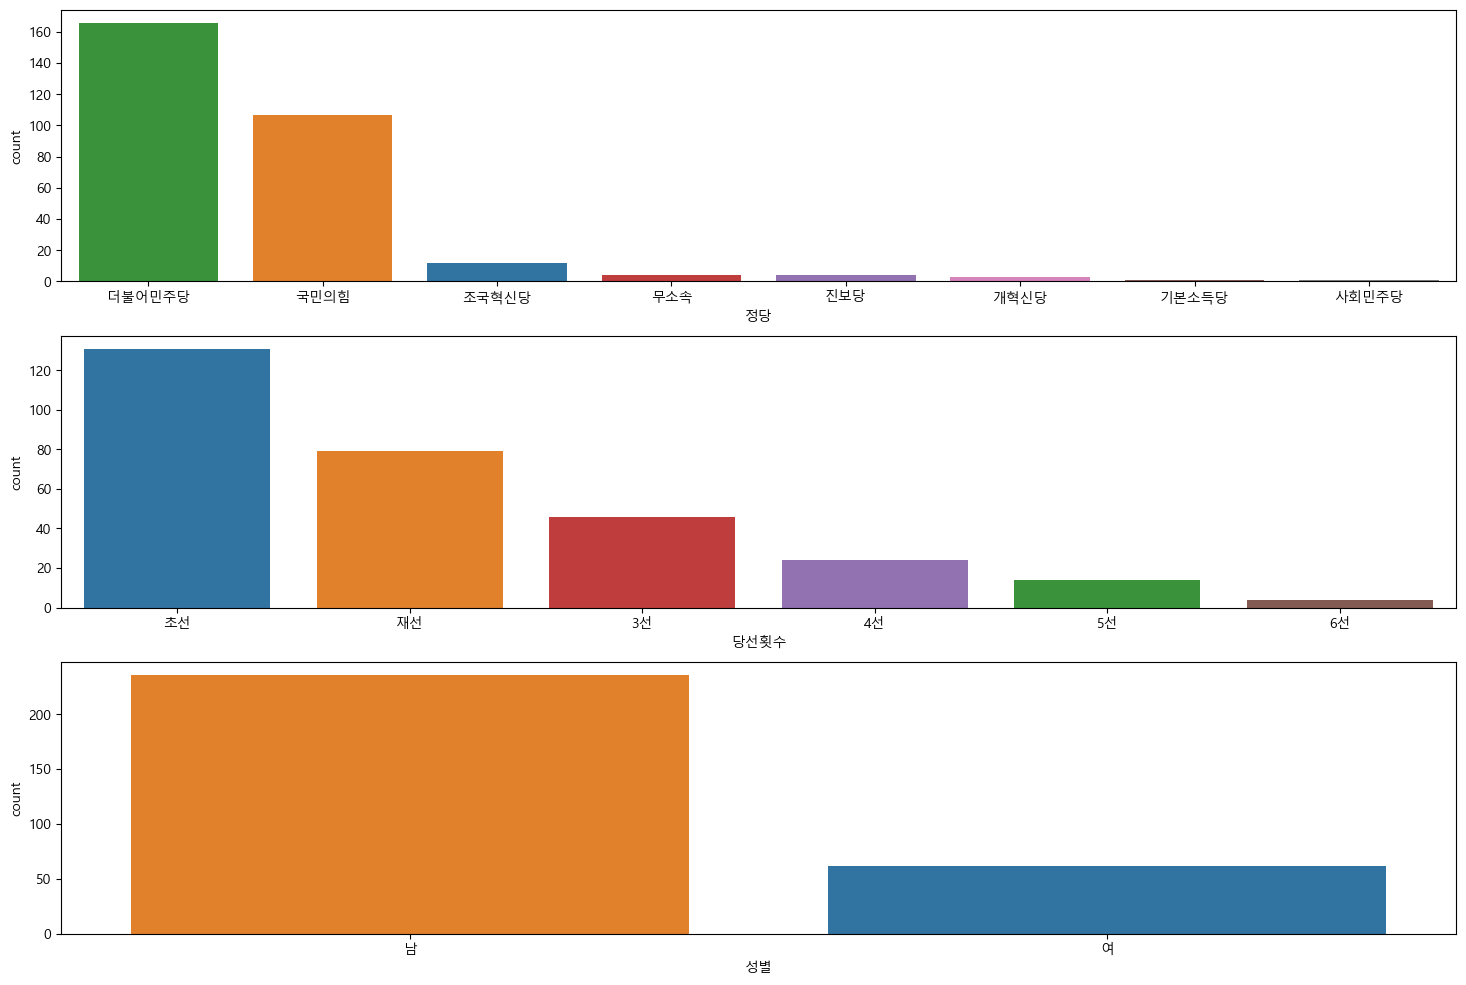

In [29]:
figure, (axes1,axes2,axes3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,12)

sns.countplot(data=member_df, x='정당', ax=axes1, order=member_df['정당'].value_counts().index, hue='정당')
sns.countplot(data=member_df, x='당선횟수', ax=axes2, order=member_df['당선횟수'].value_counts().index, hue='당선횟수')
sns.countplot(data=member_df, x='성별', ax=axes3, order=member_df['성별'].value_counts().index, hue='성별')

plt.show()

#### Matplotlib 의 Pie Plot 그려보기

In [30]:
cdf = member_df['선거구2'].value_counts(normalize=True)
print(cdf.index)
cdf

Index(['경기', '서울', '비례', '부산', '경남', '경북', '인천', '대구', '전북', '충남', '전남', '충북',
       '광주', '강원', '대전', '울산', '제주', '세종'],
      dtype='object', name='선거구2')


선거구2
경기    0.201342
서울    0.161074
비례    0.154362
부산    0.060403
경남    0.053691
경북    0.043624
인천    0.043624
대구    0.040268
전북    0.033557
충남    0.033557
전남    0.033557
충북    0.026846
광주    0.026846
강원    0.026846
대전    0.023490
울산    0.020134
제주    0.010067
세종    0.006711
Name: proportion, dtype: float64

<class 'matplotlib.figure.Figure'>


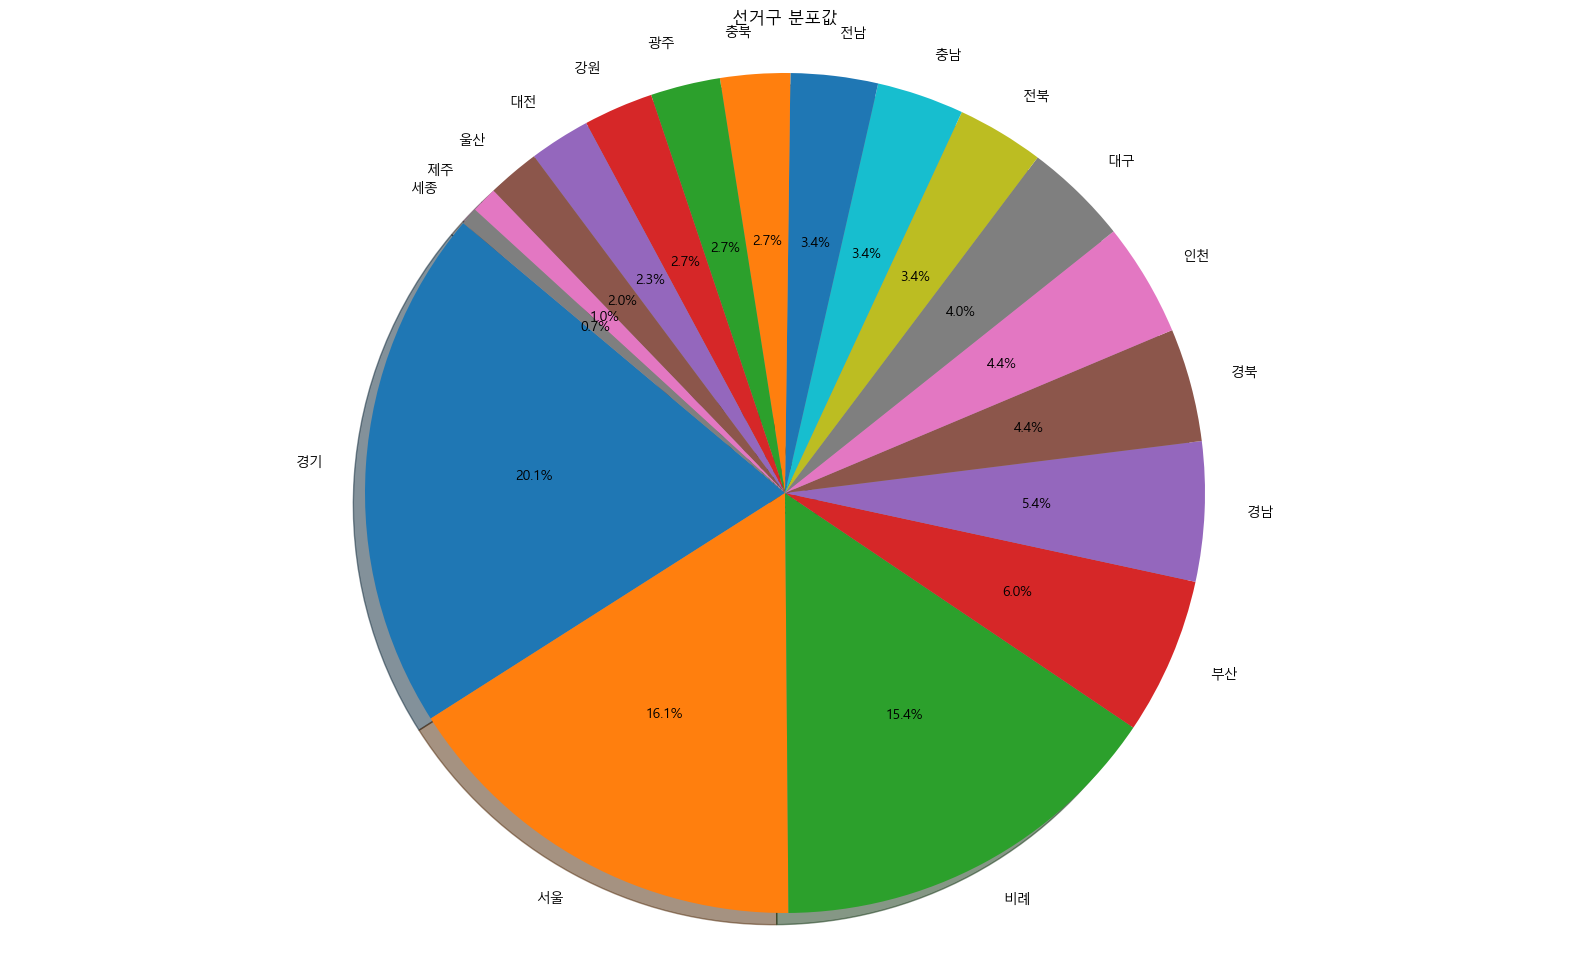

In [31]:
# figure size 설정
figure = plt.figure(figsize=(20,12))
print(type(figure))
# pie() 함수 - matplotlig의 pie plot을 그려주는 함수
plt.pie(cdf, labels=cdf.index, autopct='%1.1f%%', startangle=140, shadow=True)
# pie plot을 그릴때 원의 형태를 유지하도록 하는 설정
plt.axis('equal')
plt.title('선거구 분포값')
plt.show()

#### Seaborn의 HistPlot (분포도)
* 히스토그램은 구간에 따른 Count를 표현하기 때문에, y는 count로 고정되어 있어 x값만 설정하면 됩니다. ( x 와 y 중에서 하나만 설정하면 됩니다.)
* hue 옵션은 값에 따라 Plot의 색을 다르게 표현할 수 있다.
* multiple = 'dodge'|'stack'

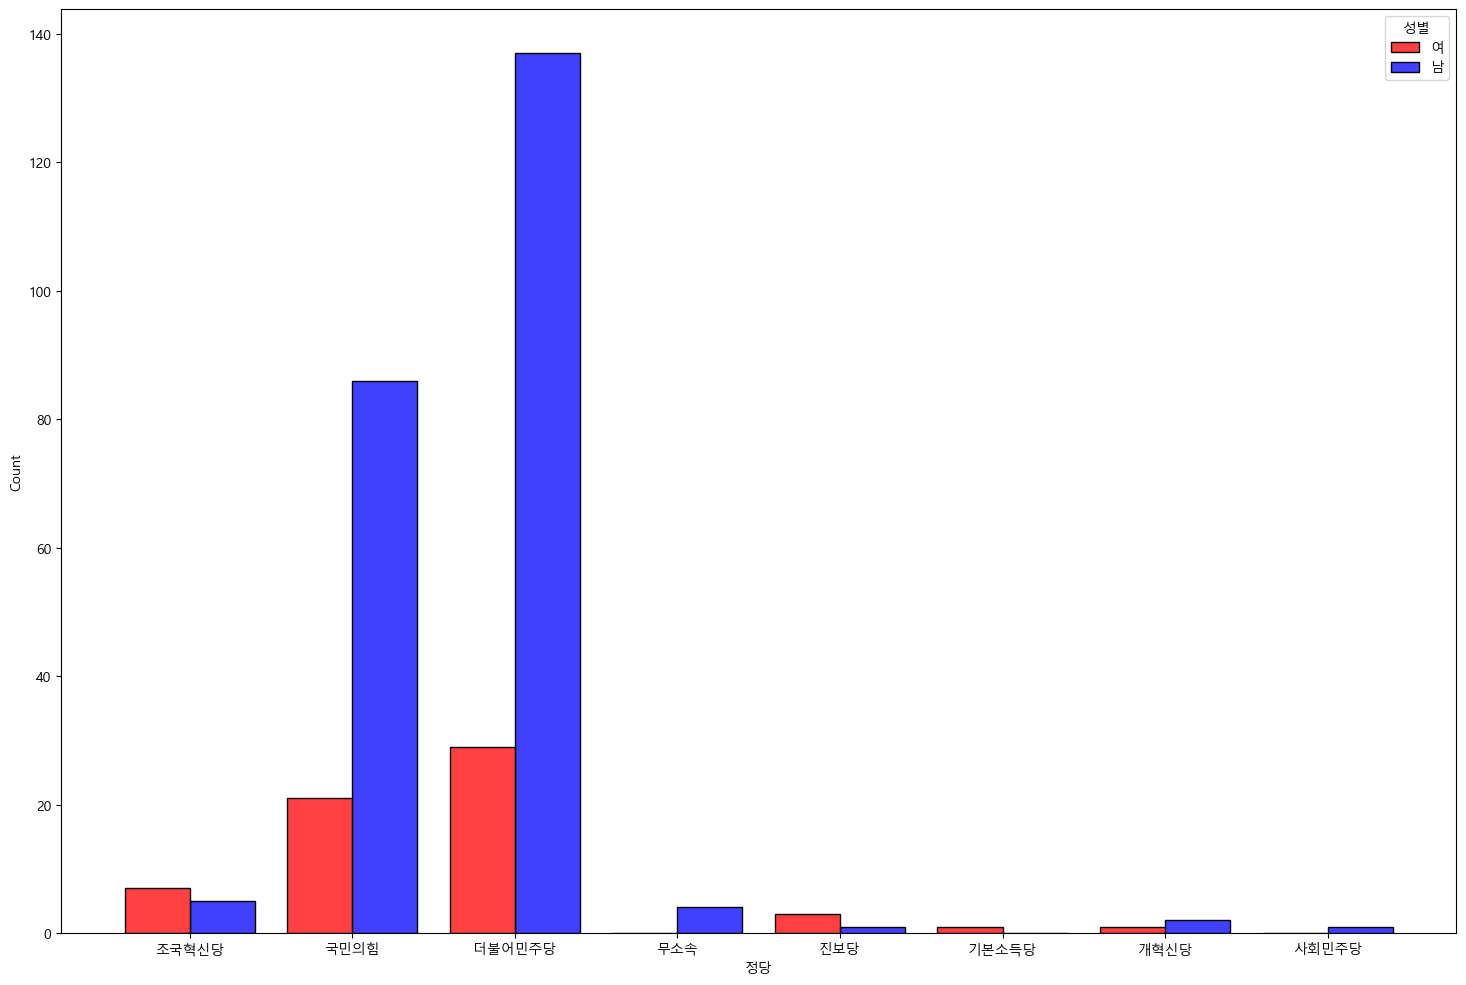

In [34]:
figure, axes1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18,12)

_ = sns.histplot(data=member_df, x='정당', ax=axes1, hue='성별', multiple='dodge',
             palette={'남': 'blue', '여': 'red'}, shrink=0.8)
plt.show()

In [35]:
member_df.loc[member_df['정당'] == '조국혁신당',['이름','성별']]

,이름,성별
1,강경숙,여
40,김선민,여
63,김재원,여
70,김준형,남
106,박은정,여
124,백선희,여
136,서왕진,남
152,신장식,남
220,이해민,여
250,정춘생,여


In [36]:
member_df.loc[member_df['정당'] == '조국혁신당',['이름','성별']].groupby('성별').count()

,이름
성별,
남,5
여,7


#### 다중 빈도 막대 그래프 catplot
* 다중 빈도 막대그래프는 countplot() 또는 catplot() 이 있습니다.
* hue 옵션은 변량을 색상으로 구분하는 파라미터입니다.

In [37]:
# 선거구 이름들이 빈도순으로 정렬된 리스트입니다.
s_index = member_df['선거구2'].value_counts().index
s_index

Index(['경기', '서울', '비례', '부산', '경남', '경북', '인천', '대구', '전북', '충남', '전남', '충북',
       '광주', '강원', '대전', '울산', '제주', '세종'],
      dtype='object', name='선거구2')

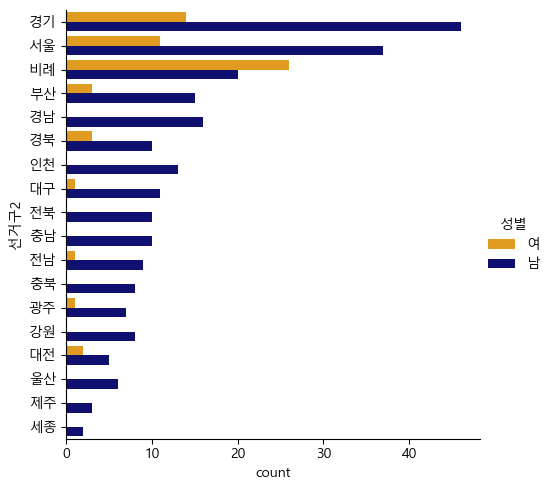

In [40]:
# figure, axes1 = plt.subplots(nrows=1, ncols=1)
# figure.set_size_inches(24,12)

_ = sns.catplot(data=member_df, y='선거구2', hue='성별', kind='count',
             palette={'남': 'navy', '여': 'orange'},
             order=s_index)
plt.show()

#### 히스토그램을 만드는 displot
* hue와 palette를 사용하여 색상을 지정할 수 있습니다.
* col 옵션은 성별에 따라 서브플롯을 나누어서 그려줍니다.

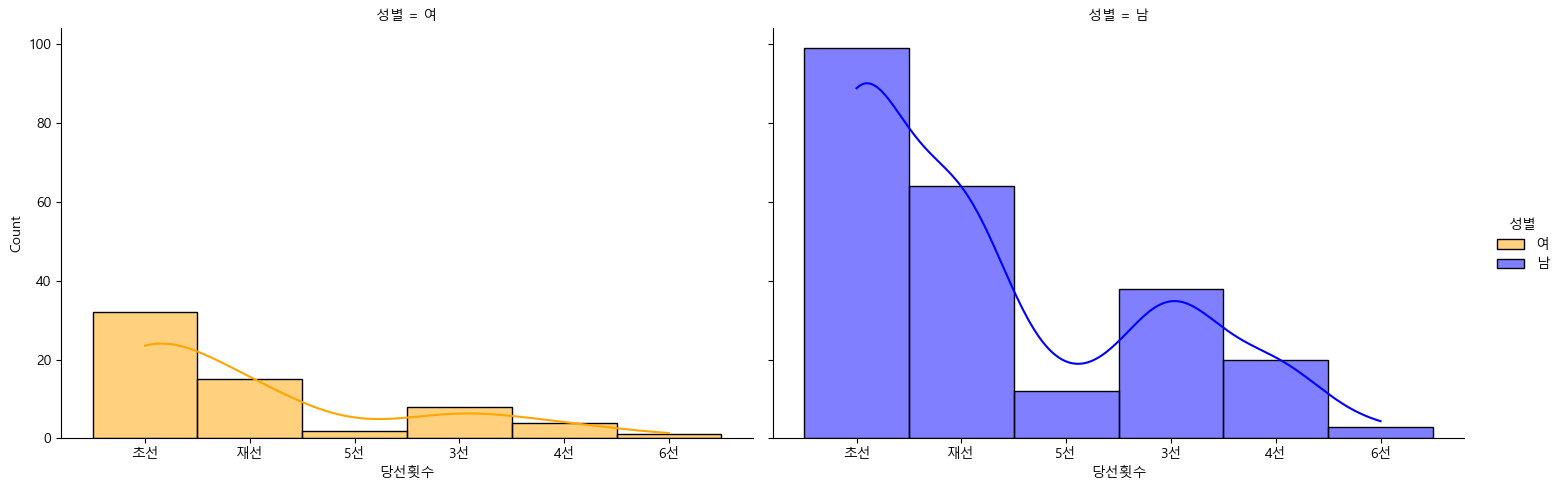

In [41]:
_ = sns.displot(
    data=member_df,
    x='당선횟수',
    hue='성별',  # 성별에 따라 색상 구분
    col='성별',  # 성별에 따라 캔버스 구분
    palette={'남': 'blue', '여': 'orange'},  # 색상 지정
    kde=True,  # 커널 밀도 추정 곡선 추가 (선택 사항)
    height=5,  # 각 플롯의 높이
    aspect=1.5  # 각 플롯의 가로 세로 비율
)
plt.show()